# Assesing the TESS-W sensor spectral response.

The TESS-W photometer mounts a TSL237 light-to-frequency plus a UV/IR cutoff filter where the IR part is limited to 750nm. An experimental measurement run of the whole device spectral response was made using the LICA Optical Test Bench, measuring the output frequency of the TESS-W device at a given wavelength, ranging from 350 nm to 1049 nm. An OSI PIN-10D calibrated laboratory photodiode was used as a reference comparison. We'd also like to compare the obtained results with the TSL237 manufacturer datasheet.

The output of the measurement session is a series of CSV files for the TESS-W and the laboratory photodiode. This Jupyter notebook shows a reduction session for this measurements an also the comparison between the theoretical values and the ones obtained at LICA.

To help us with the task, we have devoloped a Python package, namely `licatools` that performs the data reduction process (thus keeping this notebook short) and is also able to produce some graphics standalone (not using Jupyter). There is also a basic `lica` Python package which contains information about the laboratory photodiodes.

The `licatools` package makes heavy use of [Astropy's Tables](https://docs.astropy.org/en/stable/table/index.html). Theses tables are stored as ECSV files and contain the original measurements along with additional columns produced by the processing and metadata for bookeeping purposes.

## Installation

To be able to replicate the results of this notebook, the following steps are needed:

1. Download the [source code](https://github.com/guaix-ucm/licaplot) from GitHub using the command
`git clone https://github.com/guaix-ucm/licaplot.git licatools`. The `data/` subdirectory containing the datasets is not packaged with `licatools`. ***We are only interested in the `data/` subdirectory***
2. Create a virtual environment inside the `licatools/` directory and <u>activate it</u>.
3. Install `licatools` and `jupyter` in the same environment with `pip` (`pip install licatools[extras]`)
4. Run `jupyter notebook`
5. Navigate with the browser to the `doc` folder and open the `TESS-W Spectral Response.ipynb` notebook.

## The preamble 

First we start by importing the necessary Python packages, functions and constants. 


In [1]:
import itertools
from pathlib import Path
from typing import Optional, Sequence, Iterable, Tuple

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, Column
import astropy.units as u
from astropy.constants import astropyconst20 as const

from lica.lab.photodiode import PhotodiodeModel, COL, BENCH
from licatools import filters, tessw
from licatools.utils import processing
from licatools.utils.mpl import (
    plot_single_table_column, 
    plot_single_table_columns, 
    plot_single_tables_columns,
)


It is also very useful to verify that all files exists can be accessed before using the data reduction routines. The actual sample data are not packaged with `licatools` itself, but they are available in the [`licatools` GitHub repository](https://github.com/guaix-ucm/licaplot), unde the `data` directory.


In [2]:
DATA_DIR1 = Path("../data/tessw").resolve()
DATA_DIR2 = Path("../data/filters").resolve()

UVIR_FILTER_PATH = DATA_DIR2 / "IR_cut" / "SP750_QEdata.txt"
UVIR_FILTER_PHOTOD_PATH = DATA_DIR2 / "IR_cut" / "SP750_Photodiode_QEdata.txt"
TESSW_READINGS_PATH =  DATA_DIR1 / "stars1277-frequencies.csv"
TESSW_PHOTOD_PATH = DATA_DIR1 / "stars1277-photodiode.csv"
TSL237_DATASHEET_PATH = DATA_DIR1 / "TSL237_normalized_responsivity.csv"

assert UVIR_FILTER_PATH.exists()
assert UVIR_FILTER_PHOTOD_PATH.exists()
assert TESSW_READINGS_PATH.exists()
assert TESSW_PHOTOD_PATH.exists()
assert TSL237_DATASHEET_PATH.exists()

We also define a couple of useful functions to plot results obtained by the processing

The convenient function below allows to an overlapped plot of a series of input Astropy Table columns. The `filters` flag allows us to display where the LICA Optical Test Bench changes rejection filters.

## Obtaining the theoretical spectral response

What we understand by a sensor `Spectral Response` is actually the Quantum Efficiency $QE$ of such device, as given by the formula:

$$
QE = \frac{h c R_e}{\lambda}
$$

where $h$ is the Planck's constant, $c$ is the speed of the light in m/s, $\lambda$ is the wavelength in m and $R_e$ is the device Responsivity in ***A/W*** so that $QE$ is dimensioneless and $<1$. Responsivity $R_e$ is a more engineering measure of a photodiode performance and this is what can be found in datasheets. 

In the case of the TSL237, a light to frequency converter, the manufacturer gives a similar magnitude $R_e^{\prime}$ in $kHz/(μW/cm^2)$. The datasheet presents the following ***normalized*** responsivity curve $[R_e^\prime]_{norm}$ (see figure below).  

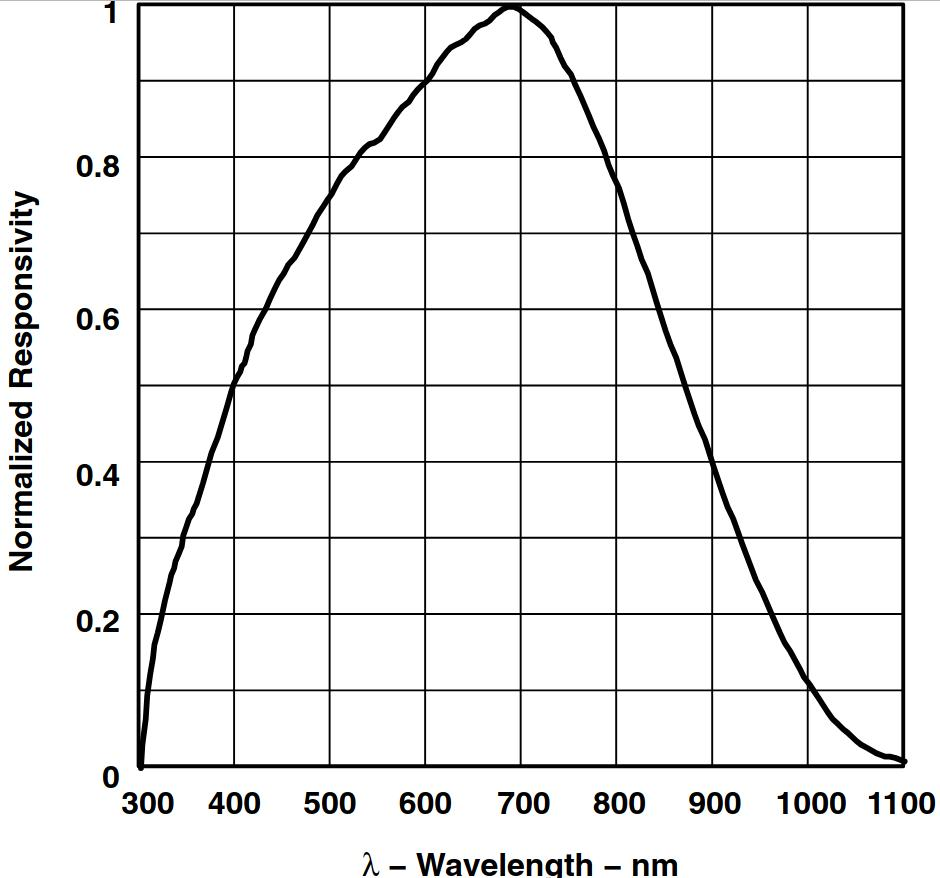

The datasheet also contains a reference point at $\lambda_{ref} = 532 nm$ where $R_e^\prime(\lambda_{ref}) = 2.3 kHz/(μW/cm^2)$ so that we can denormalize the data and express them in physical units of $(Hz/W/m^2)$:

$$
R_e^\prime = [R_e^\prime]_{norm} \times \frac{R_e^\prime(\lambda_{ref})}{[R_e^\prime(\lambda_{ref})]_{norm}} 
$$

And finally convert it to $R_e$ in $A/W$ by:

$$
R_e = \frac{R_e^\prime}{S} \times g_1
$$

where S is the photosensitive area $S = 0.92 mm^2$ and the gain $g_1$ in A/Hz converts from Hz/W to A/W. This factor is unknown and for the time being, we introduce a ficticious gain of $1 pA/W$. We will have to address later on.

All the formulae presented above require the use of standard units. The use of Astropy units gives flexibility in declaring variables with not standard units and perform the conversions automatically, raising exceptions in case of non-conformity.

We started the practical work by extracting the (x,y) datapoints from this graphics with the help of a digitizer tool and stored them in `TSL237_DATASHEET_PATH` CSV file. The file shows irregular sampling, which is resampled at 1 nm uniform resolution and trimmed to the LICA Optical TestBench range of 350-1050 nm.

In [3]:
tsl237_table = processing.tsl237_table(
    path = TSL237_DATASHEET_PATH, 
    label = "TSL237 datasheet", 
    resolution = 1,
    gain =  1 * (u.pA / u.Hz),
    sensor_area = 0.92 * u.mm**2,
    ref_point = ( 532 * u.nm, 2.3 * u.kHz / (u.uW / u.cm**2))
)

In [4]:
print(tsl237_table.meta)

{'Gain': <Quantity 1. pA / Hz>, 'Reference wavelenght': <Quantity 532. nm>, 'Reference responsivity': <Quantity 2.3 cm2 kHz / uW>, 'Photosensitive area': <Quantity 0.92 mm2>}


Since the measurements are made with a 5nm step, we decimate the above table

In [5]:
tsl237_table = tsl237_table[::5]

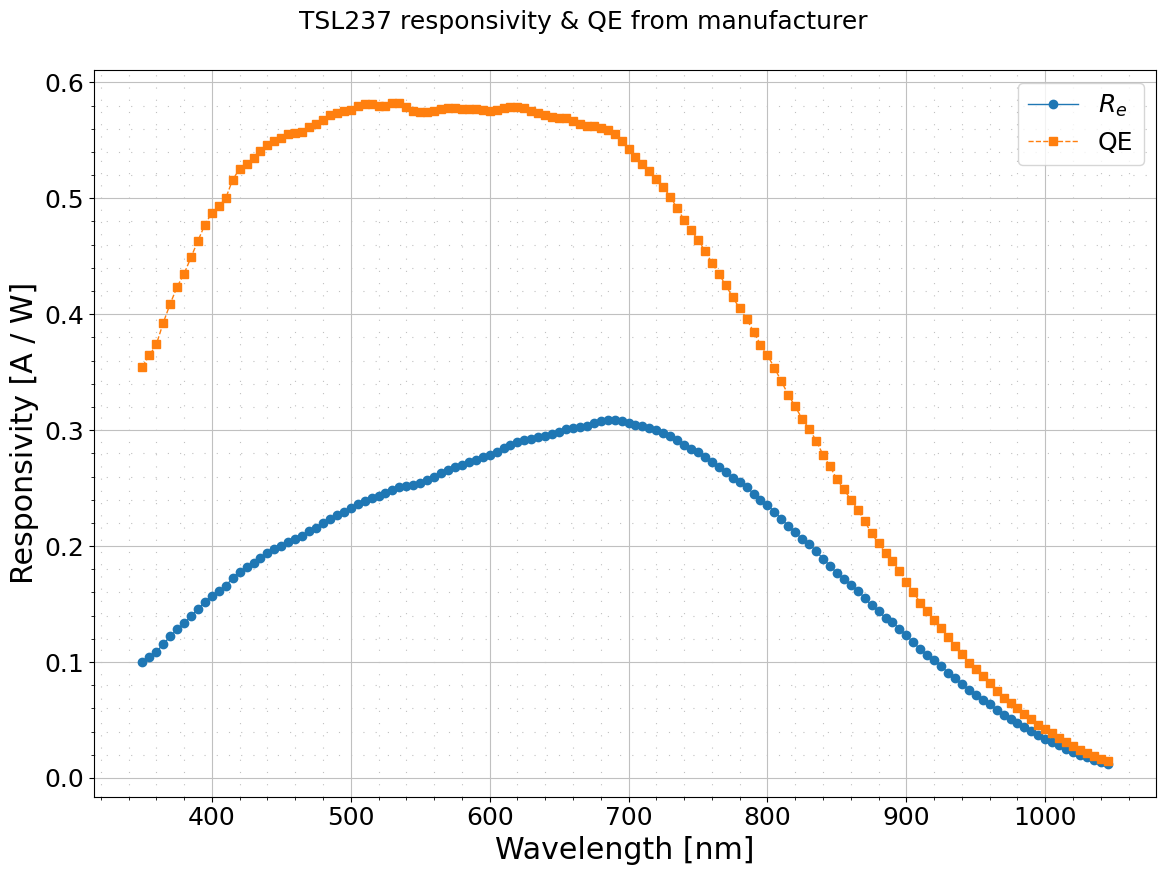

In [6]:
plot_single_table_columns(
    table = tsl237_table,
    xcolname = COL.WAVE,
    ycolnames = [COL.RESP, COL.QE],
    title = "TSL237 responsivity & QE from manufacturer",
    legends = ["$R_e$", "QE"],
)

To be able to compare the TSL237 `QE` with the measured the TESS-W `Spectral Response`, we must cut off this spectrum by the UV/IR cutoff filter used by TESS-W. As we do not have the transmission curve for this UV/IR filter, we measured one of such filters in the LICA Test Bench. The function below process the clear and filtered reference photodiode readings to return an Astropy table, saved in ECSV format. This table contains a `Transmission` column with the computed filter transmission.

In [7]:
filter_path = filters.one_filter(
    input_path = UVIR_FILTER_PATH,
    photod_path = UVIR_FILTER_PHOTOD_PATH,
    model = PhotodiodeModel.OSI.value,
    title = "UV/IR cut 750nm",
    label = "UV/IR750",
    x_low = BENCH.WAVE_START,
    x_high = BENCH.WAVE_END,
    tag = None,
    ndf = None,
)
print(filter_path)

/home/rafa/repos/own/guaix/licatools/data/filters/IR_cut/SP750_QEdata.ecsv


Now, we perform the correction multiplying the TSL237 `QE` by the cut-off filter `Transmission`

In [8]:
filter_table = processing.read_ecsv(filter_path)
filter_table

Wavelength,Electrical Current,Photodiode Electrical Current,Transmittance
nm,A,A,
float64,float64,float64,float64
350.0,3.64528e-10,2.904456e-09,0.1255064631724495
355.0,3.78757e-10,4.337138e-09,0.0873287868635953
360.0,4.01855e-10,5.918378e-09,0.0678995157119062
365.0,4.15064e-10,7.630652e-09,0.05439430339635459
370.0,4.19432e-10,9.594755e-09,0.04371471705113887
375.0,4.35865e-10,1.2069002e-08,0.036114419402697925
380.0,4.56245e-10,1.5223848e-08,0.02996909848285401
385.0,4.92346e-10,1.9190339e-08,0.02565593030951668


In [9]:

tsl237_table["Corrected QE"] = np.round(tsl237_table[COL.QE] * 
                                                       filter_table["Transmittance"], decimals=5) * u.dimensionless_unscaled

In [10]:
tsl237_table

Wavelength,Responsivity,QE,Corrected QE
nm,A / W,,
float64,float64,float64,float64
350.0,0.10019,0.3549,0.04454
355.0,0.10437,0.36453,0.03183
360.0,0.10857,0.37391,0.02539
365.0,0.11559,0.39264,0.02136
370.0,0.12205,0.40898,0.01788
375.0,0.12816,0.42373,0.0153
380.0,0.13328,0.43484,0.01303
385.0,0.1395,0.44924,0.01153


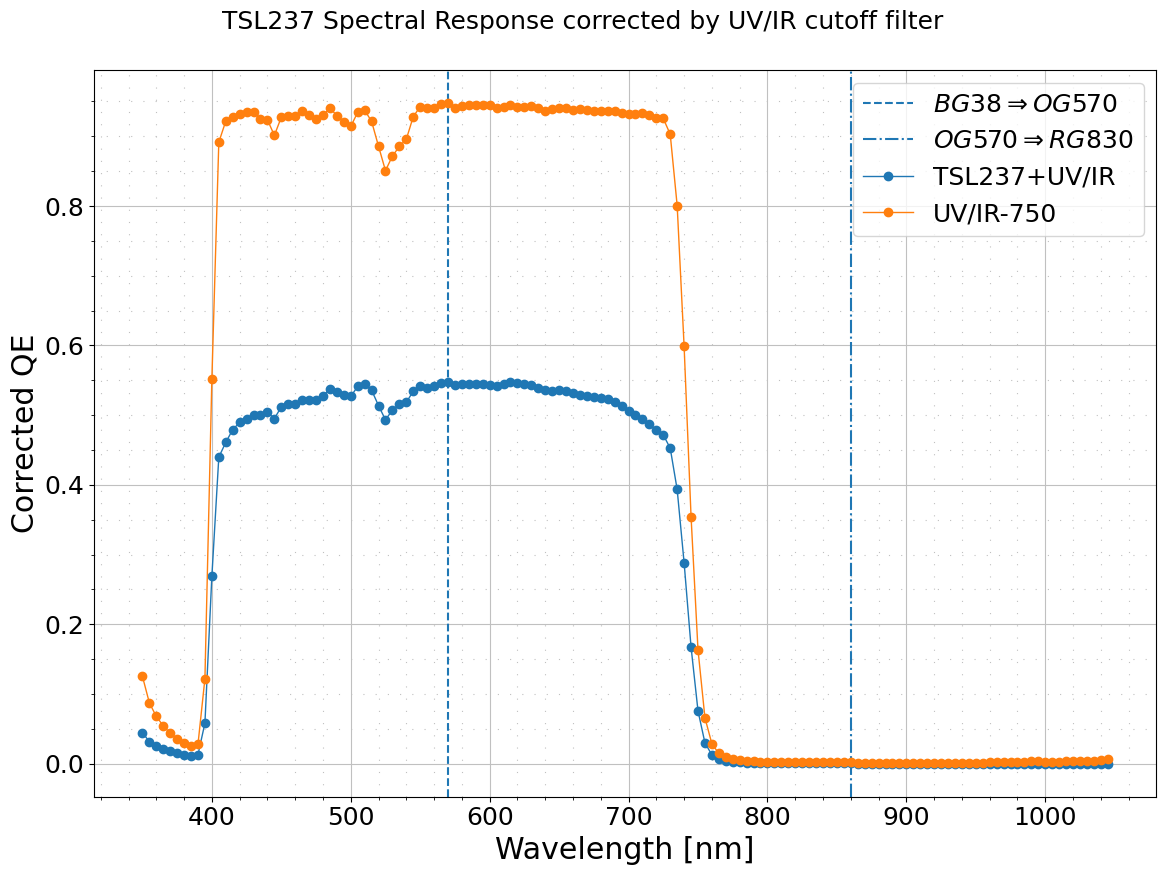

In [11]:
plot_single_tables_columns(
    tables = [tsl237_table, filter_table],
    xcolname = COL.WAVE,
    ycolnames = ["Corrected QE", "Transmittance"],
    title = "TSL237 Spectral Response corrected by UV/IR cutoff filter",
    legends = ["TSL237+UV/IR", "UV/IR-750"],
)

As we mentioned earlier, the actiual value of the TSL237+UV/IR filter is arbitrary due to the arbitrary gain factor we introduced. Note, however, the dip in the TESL237 curve above is due to this particular UV/IR cutoff filter sample we chose.

## TESS-W measured Spectral Response

The function below reads the input CSV files obtained by the TESS-W adcquistion program and the laboratory photodiode readings and performs the data reduction to obtain a table which contains a `Spectral Response` (the sensor $QE$). 

Under the even illumination conditions given by the LICA Optical test bench, and using a laboratoty photodiode with a known, calibrated quantum efficiency curve $QE_D$:

$$
    \frac{QE}{QE_D} = \frac{S_D}{S_T} \times \frac{I_T}{I_D} 
$$

where $QE$ is the TSL237 quantum eficiency, $I_D$ is the measured photodiode current, $I_T$ is the TSL237 generated current, $S_D$ is the photodiode photosensitive area and $S_T$ is the TSL237 photosensitive area.

The TSL237 device is a photodiode whose frequency $f_T$ is proportional to the generated current $I_D$ through a gain factor $g_2$ in $A/Hz$ similar to the one we mentoioned earlier :

$$
    QE =  QE_D \times \frac{S_D}{S_T} \times \frac{f_T \times g_2}{I_D}
    $$

 Again, since the gain $g_2$ is unknown, we use a ficticious `gain` factor of 1 nA/Hz.

The function below is also given the reference photodiode model used (an OSI PIN-10D) so that it can access to its tabulated ($QE_D$) and metadata ($S_D$).

In [12]:
tessw_path = tessw.one_tessw(
    input_path = TESSW_READINGS_PATH,
    photod_path = TESSW_PHOTOD_PATH,
    model = PhotodiodeModel.OSI.value,
    label = "TESS-W",
    sensor_area = 0.92 * u.mm**2,
    gain = 1 * u.nA / u.Hz,
    x_low = BENCH.WAVE_START,
    x_high = BENCH.WAVE_END,
    tag = None,
)
print(tessw_path)

/home/rafa/repos/own/guaix/licatools/data/tessw/stars1277-frequencies.ecsv


In [13]:
# Read and normalize the spectral response
tessw_table = processing.read_ecsv(tessw_path)
tessw_table[COL.QE] = tessw_table[COL.QE]/ np.max(tessw_table[COL.QE])

The first rows are shown below:

In [14]:
tessw_table

Wavelength,Frequency,Photodiode Electrical Current,Photodiode QE,QE
nm,Hz,A,,
float64,float64,float64,float64,float64
350.0,0.78,2.776791e-10,0.14864,0.15180835307804214
355.0,0.9,3.919527e-10,0.13144,0.10973492166056187
360.0,1.05,5.346517e-10,0.12158,0.08681383269258153
365.0,1.2111764705882353,7.155688e-10,0.11612,0.07146141217743188
370.0,1.3952941176470588,9.499679e-10,0.11535,0.061600313707639694
375.0,1.7,1.274078e-09,0.11941,0.05792980988916972
380.0,3.683529411764706,1.714312e-09,0.12681,0.09906864783089518
385.0,10.691176470588234,2.333952e-09,0.13722,0.22853857778756304


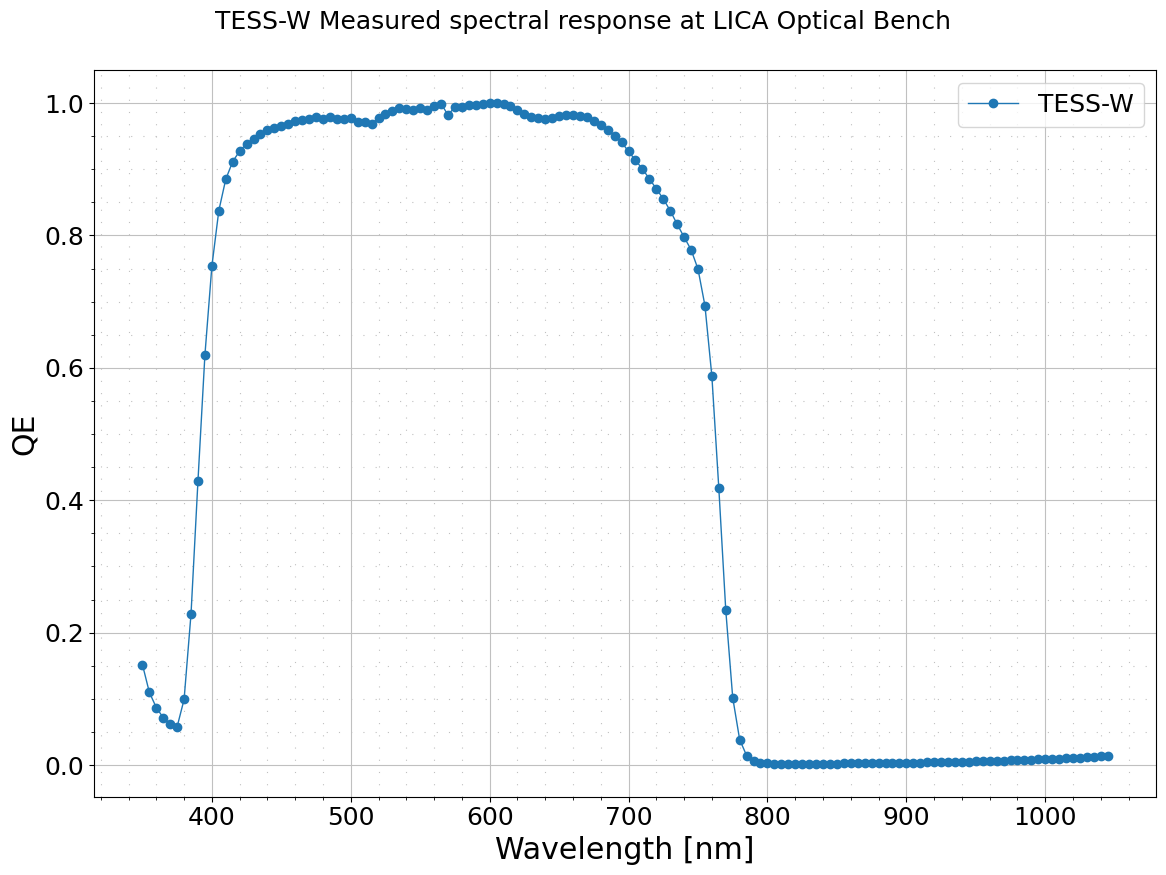

In [15]:
plot_single_table_column(
    table = tessw_table,
    xcolname = COL.WAVE,
    ycolname = "QE",
    title = "TESS-W Measured spectral response at LICA Optical Bench",
    legend = "TESS-W",
)


# Comparison of results

Let's plot the two normalized curves:

In [16]:
tsl237_table["Corrected QE"] = tsl237_table["Corrected QE"]/np.max(tsl237_table["Corrected QE"])

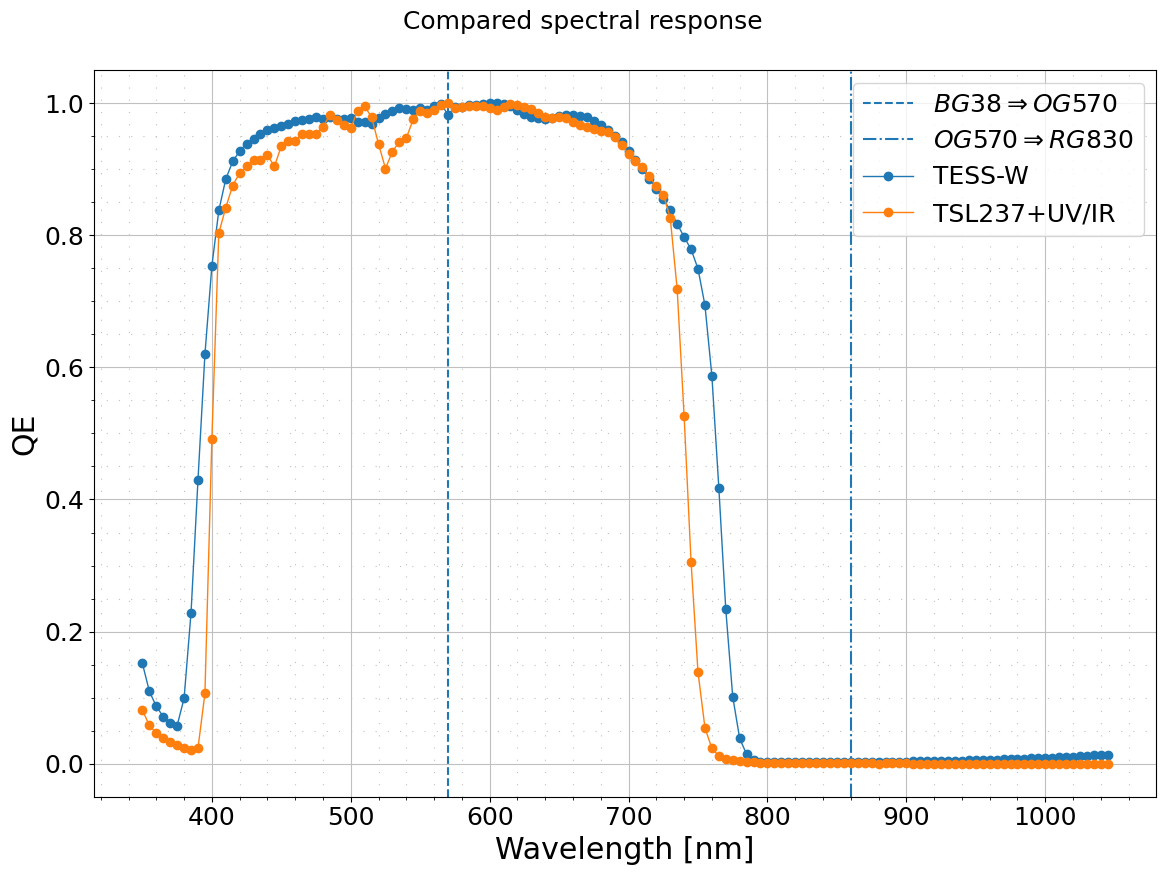

In [17]:
plot_single_tables_columns(
    tables = [tessw_table, tsl237_table],
    xcolname = COL.WAVE,
    ycolnames = ["QE","Corrected QE"],
    title = "Compared spectral response",
    legends = ["TESS-W", "TSL237+UV/IR"],
)

# Conclussion

Although he have not computed the true curve for both cases, the normlized plot shows that the laboratory procedure to estimate the TSL237 spectral response is correct. The figure alsoe suggest that the TESS-W unit under test device mounts a slightly wider UV/IR cut off filter.